# Linear and Cyclical Workflows using Functions and States

Using the functions in `autora.workflow`, we can build extremely simple and flexible pipelines and cycles which
operate on state objects.


In [ ]:
from typing import Optional

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from dataclasses import field, dataclass

from autora.workflow_ import State, Delta, wrap_to_use_state
from autora.workflow_.wrapper import theorist_from_estimator, experiment_runner_from_x_to_y_function
from autora.variable import VariableCollection, Variable


We define a two part AER pipeline consisting of an experiment runner and a theorist (we use the seed conditions
always).

The key part here is that both experiment runner and theorist are functions which:
- operate on the `State`, and
- return a modified object of the **same type** `State.

We define the state as a dataclass, subclassed from `autora.workflow_.State` with fields representing the variables,
parameters, experimental data, (possibly) conditions, and (possibly) a model.

This state has no "history"; it represents a snapshot of the data at one time. Other exemplar state objects are
available in the subpackage `autora.workflow.state` and include some with in-built histories.

In [ ]:
@dataclass(frozen=True)
class Snapshot(State):
    variables: VariableCollection = field(metadata={"delta": "replace"})
    params: dict = field(metadata={"delta": "replace"})
    experimental_data: pd.DataFrame = field(metadata={"delta": "extend"})
    conditions: pd.Series = field(default=None, metadata={"delta": "replace"})
    model: Optional[BaseEstimator] = field(default=None, metadata={"delta": "replace"})

s = Snapshot(
    variables=VariableCollection(independent_variables=[Variable("x", value_range=(-15,15))],
                                 dependent_variables=[Variable("y")]),
    params={},
    conditions=pd.Series(data=np.linspace(-15,15,101), name="x"),
    experimental_data = pd.DataFrame(columns=["x","y"]),
)

In [ ]:
s

Snapshot(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), params={}, experimental_data=Empty DataFrame
Columns: [x, y]
Index: [], conditions=0     -15.0
1     -14.7
2     -14.4
3     -14.1
4     -13.8
       ... 
96     13.8
97     14.1
98     14.4
99     14.7
100    15.0
Name: x, Length: 101, dtype: float64, model=None)

For this example, we'll use a polynomial of degree 3 as our "ground truth" function. We're also using pandas
DataFrames and Series as our data interchange format.

In [ ]:
coefs = [432, -144, -3, 1] # from https://www.maa.org/sites/default/files/0025570x28304.di021116.02p0130a.pdf
def ground_truth(x: pd.Series) -> pd.Series:
    y = pd.Series(coefs[0] + coefs[1] * x + coefs[2] * x**2 + coefs[3] * x**3, name="y")
    return y

rng = np.random.default_rng(1)
def noisy_observation(x: pd.Series, std=1000) -> pd.Series:
    y = ground_truth(x) + rng.normal(0, std, len(x))
    return y

Given this state, we define a two part AER pipeline consisting of an experiment runner and a theorist. We'll just
reuse the initial seed `conditions` in this example.

First we define and test the experiment runner.

The key part here is that both the experiment runner and the theorist are functions which operate on the `State`

In [ ]:
experiment_runner = experiment_runner_from_x_to_y_function(noisy_observation)

When we run the experiment runner, we can see the updated state object which is returned – it has new experimental data.

In [ ]:
experiment_runner(s, std=1).experimental_data

,x,y
0,-15.0,-1457.137555
1,-14.7,-1276.118592
2,-14.4,-1101.794847
3,-14.1,-936.032156
4,-13.8,-779.809070
...,...,...
96,13.8,501.720106
97,14.1,608.939405
98,14.4,721.238875
99,14.7,845.281430


Now we define a theorist, which does a linear regression on the polynomial of degree 5. We define a regressor and a
method to return its feature names and coefficients, and then the theorist to handle it.

In [ ]:
# Completely standard scikit-learn pipeline regressor
regressor = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
theorist = theorist_from_estimator(regressor)

def get_equation(r):
    t = r.named_steps['polynomialfeatures'].get_feature_names_out()
    c = r.named_steps['linearregression'].coef_
    return pd.DataFrame({"t": t, "coefficient": c.reshape(t.shape)})


Now we run the theorist on the result of the experiment_runner (by chaining the two functions).

In [ ]:
t = theorist(experiment_runner(s))

The fitted coefficients are:

In [ ]:
print(get_equation(t.model))

     t  coefficient
0    1     0.000000
1    x   -78.284157
2  x^2    -6.120871
3  x^3    -0.056876
4  x^4     0.026214
5  x^5     0.003772


Now we can define the simplest pipeline which runs the experiment runner and theorist in sequence and returns the
updated state:

In [ ]:
def pipeline(state: State) -> State:
    s_ = state
    t_ = experiment_runner(s_)
    u_ = theorist(t_)
    return u_

Running this pipeline is the same as running the individual steps – just pass the state object.

In [ ]:
rng = np.random.default_rng(1)  # reset the RNG for reproducibility
u = pipeline(s)

To show what's happening, we'll show the data, best fit model and ground truth:

     t  coefficient
0    1     0.000000
1    x  -161.235264
2  x^2    -2.092934
3  x^3     1.487881
4  x^4    -0.002423
5  x^5    -0.002523


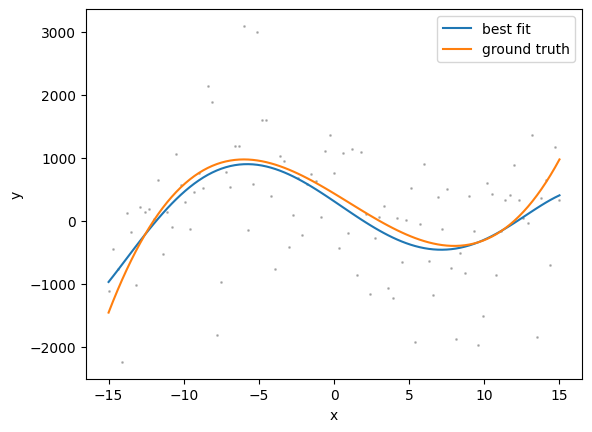

In [ ]:
def show_best_fit(state):
    state.experimental_data.plot.scatter("x", "y", s=1, alpha=0.5, c="gray")
    observed_x = sorted(state.experimental_data['x'])
    allowed_x = np.linspace(state.variables)
    plt.plot(state.conditions, state.model.predict(pd.DataFrame(u.conditions)), label="best fit")
    plt.plot(state.conditions, ground_truth(u.conditions), label="ground truth")
    plt.legend()
    print(get_equation(t.model))

show_best_fit(u)

We can use this pipeline to make a trivial cycle, where we keep on gathering data until we reach 1000 datapoints. Any
 condition defined on the state object could be used here, though.

     t  coefficient
0    1     0.000000
1    x  -118.270248
2  x^2    -3.340875
3  x^3     0.506597
4  x^4    -0.000289
5  x^5     0.001801


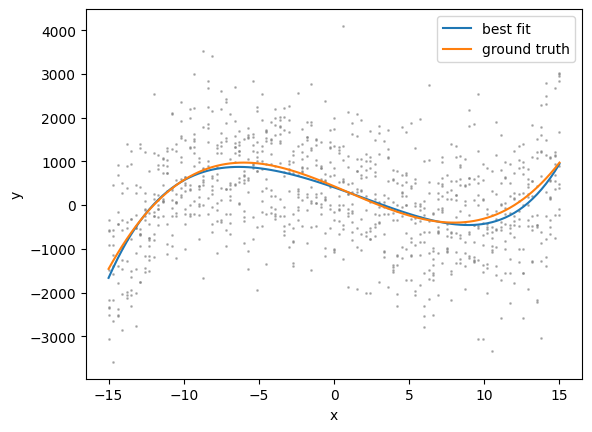

In [ ]:
v = s
while len(v.experimental_data) < 1_000:  # any condition on the state can be used here.
    v = pipeline(v)
show_best_fit(v)

We can redefine the pipeline as a generator, which can be operated on using iteration tools:

     t  coefficient
0    1     0.000000
1    x  -143.675047
2  x^2    -2.826995
3  x^3     0.971980
4  x^4    -0.000992
5  x^5     0.000145


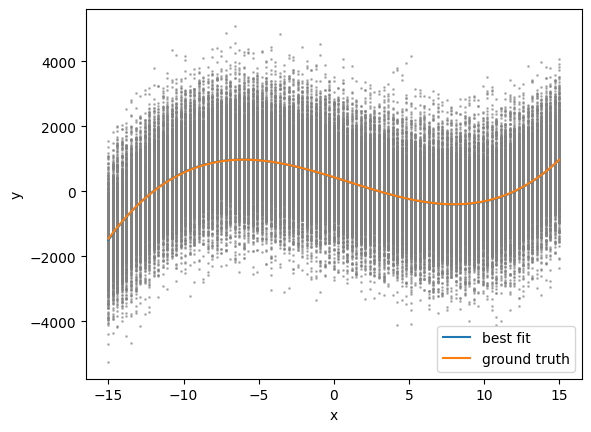

In [ ]:
def cycle(state: State) -> State:
    s_ = state
    while True:
        s_ = experiment_runner(s_)
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(s)

for i in range(1000):
    t = next(cycle_generator)
show_best_fit(t)

You can also define a cycle (or a sequence of steps) which yield the intermediate results.

In [ ]:
v0 = s
def cycle(state: State) -> State:
    s_ = state
    while True:
        print("#-- running experiment_runner --#\n")
        s_ = experiment_runner(s_)
        yield s_
        print("#-- running theorist --#\n")
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(v0)

At the outset, we have no model and an emtpy experimental_data dataframe.

In [ ]:
print(f"{v0.model=}, \n{v0.experimental_data.shape=}")

v0.model=None, 
v0.experimental_data.shape=(0, 2)


In the first `next`, we only run the "experiment_runner"

In [ ]:
v1 = next(cycle_generator)
print(f"{v1.model=}, \n{v1.experimental_data.shape=}")

#-- running experiment_runner --#

v1.model=None, 
v1.experimental_data.shape=(101, 2)


In the next step, we run the theorist on that data, but we don't add any new data:

In [ ]:
v2 = next(cycle_generator)
print(f"{v2.model=}, \n{v2.experimental_data.shape=}")

#-- running theorist --#

v2.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v2.experimental_data.shape=(101, 2)


In the next step, we run the experiment runner again and gather more observations:

In [ ]:
v3 = next(cycle_generator)
print(f"{v3.model=}, \n{v3.experimental_data.shape=}")

#-- running experiment_runner --#

v3.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v3.experimental_data.shape=(202, 2)


## Adding the experimentalist
Modifying the code to use a custom experimentalist is simple.
We define an experimentalist which adds four observations each cycle:

In [ ]:
experimentalist_rng = np.random.default_rng(180)
@wrap_to_use_state

def experimentalist(variables: VariableCollection, n_samples=101):
    names = [v.name for v in variables.independent_variables]
    low = [v.value_range[0] for v in variables.independent_variables]
    high = [v.value_range[1] for v in variables.independent_variables]
    x_range = experimentalist_rng.uniform(low, high, size=n_samples)
    conditions = pd.Series(x_range, name=names[0])
    return Delta(conditions=conditions)

experimentalist(s)

Snapshot(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), params={}, experimental_data=Empty DataFrame
Columns: [x, y]
Index: [], conditions=0       2.281691
1       5.043180
2       1.598086
3      -8.766366
4      -9.667098
         ...    
96     -6.373327
97     -4.094314
98      9.150585
99     -7.708074
100   -10.253095
Name: x, Length: 101, dtype: float64, model=None)

#-- running experimentalist --#

#-- running experiment_runner --#

#-- running theorist --#

     t  coefficient
0    1     0.000000
1    x   -94.940778
2  x^2    -5.072284
3  x^3     0.070342
4  x^4     0.010260
5  x^5     0.003901
#-- running experimentalist --#

#-- running experiment_runner --#

#-- running theorist --#

     t  coefficient
0    1     0.000000
1    x  -101.763589
2  x^2    -9.515583
3  x^3     0.345145
4  x^4     0.026752
5  x^5     0.002376
#-- running experimentalist --#

#-- running experiment_runner --#

#-- running theorist --#

     t  coefficient
0    1     0.000000
1    x   -90.058421
2  x^2    -5.598470
3  x^3     0.187811
4  x^4     0.008687
5  x^5     0.002730
#-- running experimentalist --#

#-- running experiment_runner --#

#-- running theorist --#

     t  coefficient
0    1     0.000000
1    x  -133.303564
2  x^2    -4.935111
3  x^3     0.811753
4  x^4     0.005140
5  x^5     0.000718
#-- running experimentalist --#

#-- running experiment_runner -

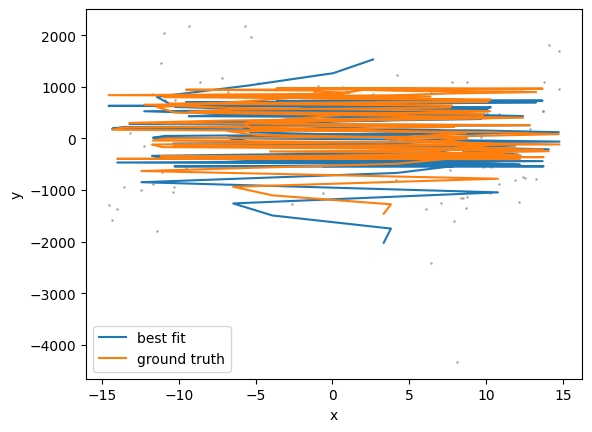

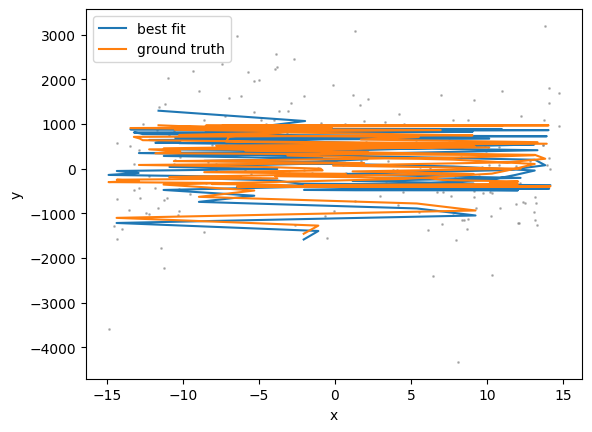

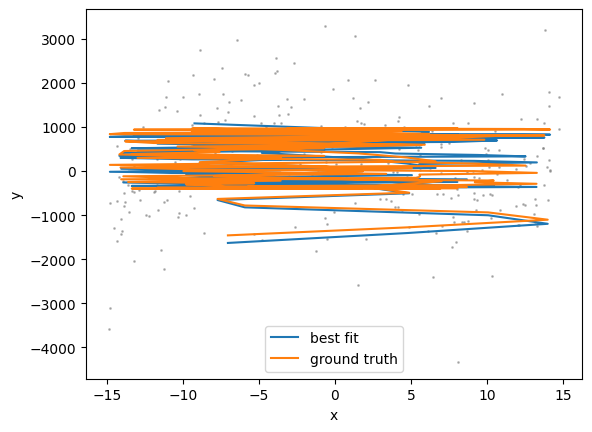

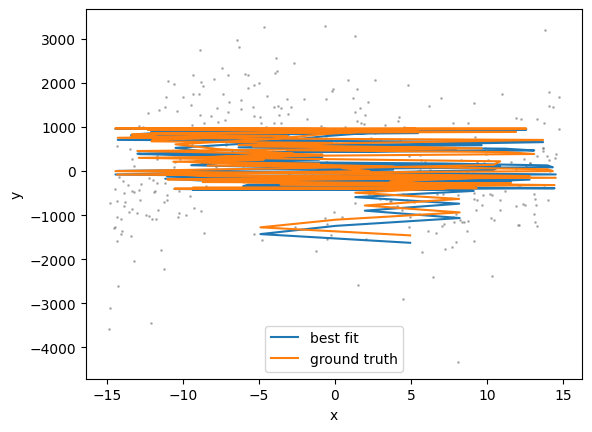

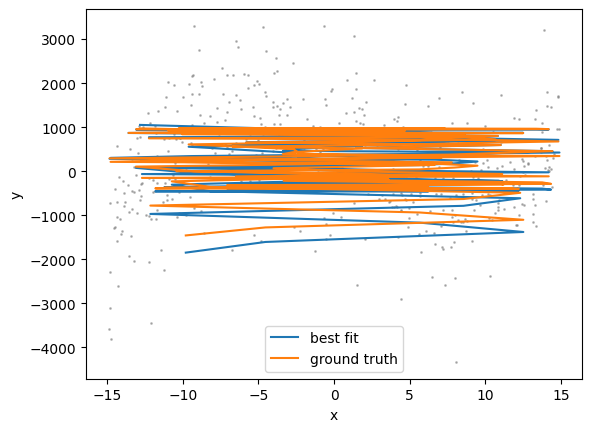

In [ ]:
u0 = s
for i in range(5):
    print("#-- running experimentalist --#\n")
    u0 = experimentalist(u0)

    print("#-- running experiment_runner --#\n")
    # TODO: fix this function so that it uses dataframes rather than series
    u0 = experiment_runner(u0)

    print("#-- running theorist --#\n")
    u0 = theorist(u0)

    # TODO: fix this function so that it plots properly across the full range, and doesn't
    # TODO: ... rely on the conditions
    show_best_fit(u0)


In [ ]:
pd.DataFrame(np.linspace(0,10,10))

,0
0,0.000000
1,1.111111
2,2.222222
3,3.333333
4,4.444444
5,5.555556
6,6.666667
7,7.777778
8,8.888889
9,10.000000
